In [2]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.7 MB/s eta 0:00:00? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 20.4 MB/s eta 0:00:0031m20.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [monai]━━━━━ 1/2 [monai]
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install faiss

ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss
Note: you may need to restart the kernel to use updated packages.


In [1]:
import nibabel as nib
import numpy as np
import os
import torch
from monai.networks.nets import SwinUNETR
import torch.nn.functional as F
from monai.inferers import sliding_window_inference
import faiss
from sklearn.decomposition import PCA
#from sklearn.decomposition import PCA
from cuml.decomposition import PCA  # GPU-accelerated PCA from RAPIDS AI

2025-05-15 14:01:56.610969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 14:01:56.618859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747299716.627534  325392 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747299716.630126  325392 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747299716.636943  325392 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

ModuleNotFoundError: No module named 'faiss'

In [27]:
def convert_feature_to_PSA_validation(feature,device):
    # Define parameters
    feature_dim = 48  # Input feature dimension
    output_size = (60, 60, 30)  # Adaptive pooling target size
    feature_dim_reduced = 32  # After PCA

    feature = feature.to(device)  # Move input tensor to GPU

    # 🔹 Apply Adaptive Average Pooling
    pooled_features = torch.nn.functional.adaptive_avg_pool3d(feature, output_size)  # Shape: (1, 48, 6, 6, 6)
    #print("Pooled Feature Shape:", pooled_features.shape)

    # 🔹 Flatten the spatial dimensions (Transform 5D -> 2D)
    flattened_features = pooled_features.view(feature_dim, -1).T  # Shape: (216, 48)
    #print("Flattened Feature Shape:", flattened_features.shape)

    # 🔹 Convert to NumPy
    flattened_features_np = flattened_features.cpu().numpy()

    # 🔹 Apply PCA to reduce dimensions (48D → 32D)
    pca = PCA(n_components=feature_dim_reduced)
    pca_features = pca.fit_transform(flattened_features_np)  # Shape: (216, 32)

    return pca_features


In [3]:
def convert_feature_to_PSA(feature, faiss_index,device):
    # Define parameters
    feature_dim = 48  # Input feature dimension
    output_size = (60, 60, 30)  # Adaptive pooling target size
    feature_dim_reduced = 32  # After PCA

    feature = feature.to(device)  # Move input tensor to GPU

    # 🔹 Apply Adaptive Average Pooling
    pooled_features = torch.nn.functional.adaptive_avg_pool3d(feature, output_size)  # Shape: (1, 48, 6, 6, 6)
    #print("Pooled Feature Shape:", pooled_features.shape)

    # 🔹 Flatten the spatial dimensions (Transform 5D -> 2D)
    flattened_features = pooled_features.view(feature_dim, -1).T  # Shape: (216, 48)
    #print("Flattened Feature Shape:", flattened_features.shape)

    # 🔹 Convert to NumPy
    flattened_features_np = flattened_features.cpu().numpy()

    # 🔹 Apply PCA to reduce dimensions (48D → 32D)
    pca = PCA(n_components=feature_dim_reduced)
    pca_features = pca.fit_transform(flattened_features_np)  # Shape: (216, 32)

    return pca_features


In [4]:
def load_faiss(hnsw_M=32, feature_dim_reduced=32):
    #res = faiss.StandardGpuResources()  # Initialize GPU resources
    faiss_index = faiss.IndexHNSWFlat(feature_dim_reduced, hnsw_M, faiss.METRIC_L2)
    #faiss_index = faiss.index_cpu_to_gpu(res, 0, faiss_index)  # Move index to GPU
    return faiss_index


In [5]:
def store_feature(extractedFeatures, faiss_index,device):
    pca_features = convert_feature_to_PSA(extractedFeatures, faiss_index,device)  # Run feature extraction

    # 🔹 Move features to GPU and add to FAISS
    pca_features = np.ascontiguousarray(pca_features.astype(np.float32))  # Ensure FAISS compatibility
    faiss_index.add(pca_features)  # Store in FAISS
    #print("✅ Features added to FAISS index!")
    return faiss_index


In [6]:
def load_mri_modalities(initial, modality_paths):
    """ Load and stack four MRI modalities into a single 4-channel tensor """
    modalities = [nib.load(os.path.join(initial, path)).get_fdata() for path in modality_paths]  # Load all modalities
    stacked = np.stack(modalities, axis=0)  # Shape: (4, H, W, D)
    return stacked.astype(np.float32)  # Convert to float32 for deep learning

def normalize_mri(mri_tensor):
    """ Apply Z-score normalization to each modality in a 4-channel MRI tensor. """
    for i in range(mri_tensor.shape[0]):  # Loop through 4 modalities
        mean = np.mean(mri_tensor[i])
        std = np.std(mri_tensor[i])
        if std > 0:  # Avoid division by zero
            mri_tensor[i] = (mri_tensor[i] - mean) / std
    return mri_tensor





In [7]:
def convert_mri_to_tensor(mri_tensor):
    """ Convert preprocessed MRI tensor to PyTorch format and move to GPU """
    tensor = torch.tensor(mri_tensor).unsqueeze(0).to(torch.float32)  # Add batch dimension
    if torch.cuda.is_available():
        tensor = tensor.to("cuda")
    return tensor

In [8]:
# Define the model structure
def load_swin_unetr_model(checkpoint_path):
    model = SwinUNETR(
        img_size=(128, 128, 128),
        in_channels=4,
        out_channels=3,
        feature_size=48,
        use_checkpoint=True,
    )
    #model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu", weights_only=False))
    checkpoint = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu",weights_only=False)
    model.load_state_dict(checkpoint["state_dict"], strict=False)  # Use "state_dict" key

    model.eval()  # Set model to evaluation mode
    return model




# Change path below

In [9]:
def load_models():
  # Load models from all 5 folds
    models = []
    initial = "/media/fast/New Volume/sufyan data/Models"
    for i in range(5):
        checkpoint_path = f"{initial}/model{i}.pt"
        models.append(load_swin_unetr_model(checkpoint_path))
    return models


In [10]:
def extract_ensemble_features_sliding_window(models, image,roi_size=(96, 96, 96), sw_batch_size=2, overlap=0.25):
    features = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for model in models:
            model = model.to(device)  # Move model to GPU/CPU
            feat = sliding_window_inference(image.to(device), roi_size, sw_batch_size, model.swinViT, overlap=overlap)[0]

            # Ensure features is a tensor

            features.append(feat)

    ensemble_features = torch.stack(features).mean(dim=0)
    return ensemble_features




In [11]:
def load_paths_of_mri(case_no , initial):
    num = f"{case_no:03d}"  # Formats i as a 3-digit string (e.g., "006", "045", "123")
    paths = [
        f"{initial}/BraTS20_Training_{num}/BraTS20_Training_{num}_t1.nii",
        f"{initial}/BraTS20_Training_{num}/BraTS20_Training_{num}_t2.nii",
        f"{initial}/BraTS20_Training_{num}/BraTS20_Training_{num}_flair.nii",
        f"{initial}/BraTS20_Training_{num}/BraTS20_Training_{num}_t1ce.nii"
    ]
    return paths



In [23]:
def load_paths_of_mri_for_validation(case_no , initial):
    num = f"{case_no:03d}"  # Formats i as a 3-digit string (e.g., "006", "045", "123")
    paths = [
        f"{initial}/BraTS20_Validation_{num}/BraTS20_Validation_{num}_t1.nii",
        f"{initial}/BraTS20_Validation_{num}/BraTS20_Validation_{num}_t2.nii",
        f"{initial}/BraTS20_Validation_{num}/BraTS20_Validation_{num}_flair.nii",
        f"{initial}/BraTS20_Validation_{num}/BraTS20_Validation_{num}_t1ce.nii"
    ]
    return paths



/home/fast/miniconda3/envs/sufyan_env/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


✅ FAISS index loaded successfully!
Index before adding new features: 17280000


# Run these

In [ ]:
models=load_models()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
faiss_index=load_faiss()
mri_cases=365

# Change path below

In [21]:
#initial="drive\MyDrive\MICCAI_BraTS2020_TrainingData"
initial="/media/fast/New Volume/sufyan data/archive(1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
for i in range(1,mri_cases+1):
        
        paths=load_paths_of_mri(i , initial)
        
        # Load MRI modalities
        mri_tensor = load_mri_modalities(initial, paths)
        
      # Apply normalization
        mri_tensor = normalize_mri(mri_tensor)
          # Expected output: (4, H, W, D)
      # Convert MRI to PyTorch tensor
        mri_tensor_torch = convert_mri_to_tensor(mri_tensor)
        #print("MRI Tensor Shape:", mri_tensor_torch.shape)  # Expected: (1, 4, 240, 240, 155)
        image=mri_tensor_torch
        image = image.to(device)  # Move input MRI to the same device

      # Extract features
        extractedFeatures = extract_ensemble_features_sliding_window(models, image)

        print("Ensemble Feature Shape:", extractedFeatures.shape)

        #pca_features=convert_feature_to_PSA(extractedFeatures,faiss_index)
        faiss_index = store_feature(extractedFeatures,faiss_index,device)
        print("✅ Features added to FAISS index!: ",i)


faiss.write_index(faiss_index, "/media/fast/New Volume/sufyan data/faiss_index.bin")




Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  161
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  162
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  163
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  164
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  165
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  166
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  167
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  168
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  169
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  170
Ensemble Feature Shape: torch.

✅ Features added to FAISS index!:  245
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  246
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  247
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  248
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  249
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  250
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  251
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  252
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  253
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  254
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS inde

✅ Features added to FAISS index!:  330
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  331
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  332
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  333
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  334
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  335
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  336
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  337
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  338
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS index!:  339
Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])
✅ Features added to FAISS inde

In [ ]:
# 🔹 Load the existing FAISS index
faiss_index = faiss.read_index("/media/fast/New Volume/sufyan data/faiss_index.bin")
print("✅ FAISS index loaded successfully!")

# 🔹 Check the existing index size
print("Index before adding new features:", faiss_index.ntotal)

# End

# Query

In [65]:
def query(case_no):
    initial="/media/fast/New Volume/sufyan data/archive(1)/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    paths=load_paths_of_mri_for_validation(case_no , initial)
        
        # Load MRI modalities
    mri_tensor = load_mri_modalities(initial, paths)
        
      # Apply normalization
    mri_tensor = normalize_mri(mri_tensor)
          # Expected output: (4, H, W, D)
      # Convert MRI to PyTorch tensor
    mri_tensor_torch = convert_mri_to_tensor(mri_tensor)
        #print("MRI Tensor Shape:", mri_tensor_torch.shape)  # Expected: (1, 4, 240, 240, 155)
    image=mri_tensor_torch
    image = image.to(device)  # Move input MRI to the same device

      # Extract features
    extractedFeatures = extract_ensemble_features_sliding_window(models, image)

    print("Ensemble Feature Shape:", extractedFeatures.shape)
    
    pca_features=convert_feature_to_PSA_validation(extractedFeatures,device)
    pca_features = np.ascontiguousarray(pca_features.astype(np.float32))  # Ensure FAISS compatibility
    return pca_features
    

In [66]:
def load_features():
    # 🔹 Load the existing FAISS index
    faiss_index = faiss.read_index("/media/fast/New Volume/sufyan data/faiss_index.bin")
    return faiss_index


# 🔹 Check the existing index size


In [67]:
def search(pca_features):
    distances, indices = faiss_index.search(pca_features, top_k)
    return distances,indices

In [68]:
def get_case_id(faiss_indices, features_per_case=108000):
    return faiss_indices // features_per_case  # ✅ Ensures integer case numbers

In [112]:
import nibabel as nib
import matplotlib.pyplot as plt

def show_image(file_path, file_path1):
    # Load the NIfTI files
    img1 = nib.load(file_path).get_fdata()
    img2 = nib.load(file_path1).get_fdata()

    # Select middle slice
    slice_index1 = img1.shape[2] // 2
    slice_index2 = img2.shape[2] // 2

    image_slice1 = img1[:, :, slice_index1]
    image_slice2 = img2[:, :, slice_index2]

    # Display images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_slice1, cmap='gray')
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    axes[1].imshow(image_slice2, cmap='gray')
    axes[1].set_title("Similar Image")
    axes[1].axis("off")

    plt.show()

# Call the function with correct paths



In [136]:
def query_image(case_no):
    initial1="/media/fast/New Volume/sufyan data/archive(1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    features=query(case_no)
    distances,indices=search(features)
    case_id=get_case_id(indices[0][0])
    paths_query=load_paths_of_mri_for_validation(case_no , initial)
    paths_similar=load_paths_of_mri(case_id , initial1)
    
    show_image(paths_query[0],paths_similar[0])
    #show1(paths_query[0])
    
    print("Distance Score:",distances[0][0])
        
    

Ensemble Feature Shape: torch.Size([1, 48, 120, 120, 77])


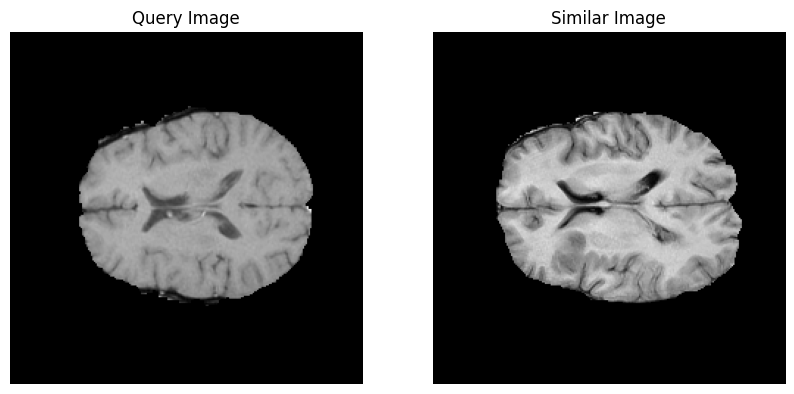

Distance Score: 1.2976294e-05


In [143]:
case_no=38
query_image(case_no)